In [1]:
###Import
import glob
import timeit
import numpy as np
import cv2 as cv
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from math import pi
plt.style.use('seaborn-whitegrid')

In [2]:
###Get dataset from csv (taken from mnist kaggle.com)
###mnist_train - is used, mnist_test is not used up to now
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [3]:
###Helpful class for debuging. Shows images, convert image batches as matrix to rgb, rescales...
###ORIGIN OF CLASS
class Debug():
    class Image():
        def __init__(self,image,label=""):
            self.image = image
            self.label = label
            
    def show_images_list(image_list, labels = [], cmap = 'gray', col_number = 10, height = 2, save_name=None, save_dir = "Data/saved_images"):
        row = -(-len(image_list)//col_number) 
        fig = plt.figure(figsize=(15, row*height))
        count = 1
        
        if save_name:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        
        for i in range(len(image_list)):
            a = fig.add_subplot(row, col_number, count)
            plt.axis('off')
            if isinstance(i, Debug.Image):
                if image_list[i].label:
                    a.set_title(image_list[i].label)
                plt.imshow(image_list[i].image, cmap = cmap) 
            else:
                if any(labels):
                    a.set_title(labels[i])
                out_img = plt.imshow(image_list[i], cmap = cmap) 
            if save_name:
                plt.imsave(os.path.join(save_dir, "%s_%s.png"%(save_name,i)), image_list[i], cmap = cmap)
            count=count+1

    def show_image(img, cmap = 'gray', no_axis = False):
        if no_axis:
            plt.axis('off')
        plt.imshow(img, cmap = cmap) 
        
    def scale_to_1(x):
        return (x/255.0)
    
    def scale_to_255(x):
        return (x*255.0)
        
    def make_rgb_from_gray(img, mode="r"):
        img = img.reshape(-1,28,28,1)
        out_shape = list(img.shape)
        out_shape[-1] = 2
        out = np.concatenate((img, np.zeros(out_shape)), axis=3)
        if mode == "r":
            return out
        if mode == "g":
            return out[:,:,:,[1,0,2]]
        if mode == "b":
            return out[:,:,:,[1,2,0]]

#Example: Debug.show_image(img.reshape(28,28))
#Example: Debug.show_images_list(debug_img_list, col_number = 3, height = 5)

In [5]:
###Create "num_samples" random conbination of "num_digits"-digits numbers
###First try with num_digits=4
num_digits = 4
num_samples = 1000

###Find minumum value of specific elements belong to one label
min_numbers = min(mnist_train['label'].value_counts())

###Create balanced data array with (10*min_numbers) elements =  (min_numbers "0" pics) + ... + (min_numbers "9" pics)
data_balanced = np.concatenate([np.array(mnist_train[mnist_train['label']==i].drop(columns=['label']))[0:min_numbers] for i in range(10)], axis=0)

###Make list of unique numbers "num_digits"-combination for creation of main picture data array
comb_ids = np.unique(np.array([np.random.randint(data_balanced.shape[0], size=num_digits) for i in range(num_samples*2)]),axis=0)[:num_samples]
print("Number of unique digits in each 0-9 class is %s"%min_numbers)
if comb_ids.shape[0] < num_samples:
    print("WARNING!!! List is shorter than required %s because of duplications, try to regenerate"%num_samples)
else:
    print("Successfully generated %s unique %s-digits combinations of numbers"%(num_samples,num_digits))
    
###Make picture data array based on balanced mnist (same amount of 0-9 digits) and new indice combination
generator_array = np.array([data_balanced[i] for i in comb_ids])

print("Shape of generator_array is", generator_array.shape)

Number of unique digits in each 0-9 class is 3795
Successfully generated 1000 unique 4-digits combinations of numbers
Shape of generator_array is (1000, 4, 784)


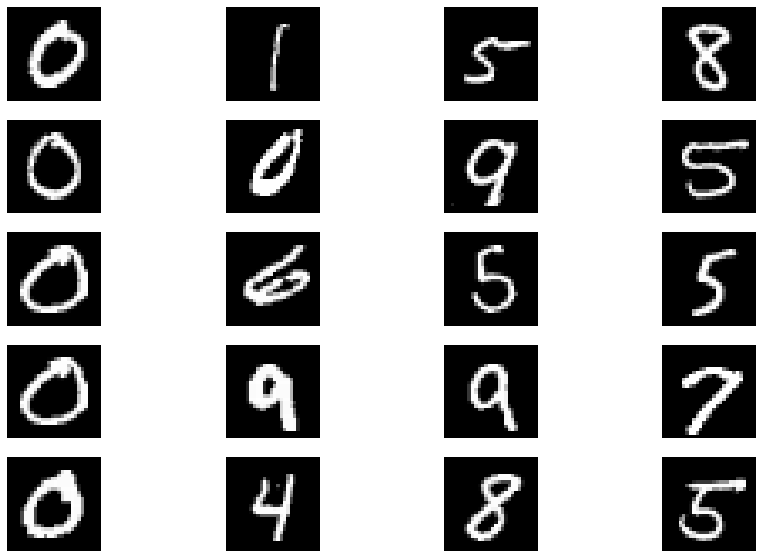

In [6]:
###Show first 5 group
###Each line will be combined into one image
Debug.show_images_list(generator_array[:5].reshape(-1,28,28), col_number = num_digits)

In [7]:
###Specian class for image transformation and augmentation
###ORIGIN OF CLASS
class Image_generator(object):
    def __init__(self, pipeline):
        self.num_classes = None
        self.num_class_samples = None
        self.pipeline = pipeline
        
    def __call__(self, inp, shuffle = False):
        #Execute pipeline
        pl1_x, pl1_y = self.pipeline(inp)
        
        #Set some data
        self.num_classes = self.pipeline.num_classes
        self.num_class_samples = self.pipeline.num_class_samples
        
        #Output x,y arrays as is or reshuffled
        if shuffle:
            pl1_x, pl1_y = self.shuffle_x_y(pl1_x, pl1_y)
        
        return pl1_x, pl1_y 
    
    ###Pipeline base classes
    class Pipeline(object):
        def __init__(self, common_layers, target_layers, special_layers):
            self.common_layers = common_layers
            self.target_layers = target_layers
            self.special_layers = special_layers
            self.num_classes = None
            self.num_class_samples = None
        
    ###Pipeline with labeles outputs
    class Pipeline_labels(Pipeline):
        def __init__(self, common_layers, target_layers, special_layers):
            super().__init__(common_layers, target_layers, special_layers)
        def __call__(self, inp):
            inp_common = inp
            inp_trans_dict = {}
            for i in self.common_layers:
                inp_common, inp_trans_dict = i(inp_common, inp_trans_dict)
            
            result_x = []
            result_y = [] 

            for p in self.special_layers:
                out = np.copy(inp_common)
                out_trans_dict = inp_trans_dict.copy()
                
                for i in p:
                    out, out_trans_dict = i(out, out_trans_dict)
                    
                result_x.append(out) 
                result_y.append(np.array([i for i in range(inp_common.shape[0])]))
                del out
            
            result_x = np.concatenate(result_x,axis=0)
            result_y = np.concatenate(result_y,axis=0)
            
            self.num_classes = result_y.max()+1
            self.num_class_samples = int(result_x.shape[0]/(self.num_classes))
            
            return result_x, result_y
    
    ###Pipeline with angles output
    class Pipeline_angles(Pipeline):
        def __init__(self, common_layers, target_layers, special_layers):
            super().__init__(common_layers, target_layers, special_layers)
        def __call__(self, inp):
            inp_common = inp
            inp_trans_dict = {}
            for i in self.common_layers:
                inp_common, inp_trans_dict = i(inp_common, inp_trans_dict)
            
            result_x = []
            result_y = [] 

            for p in self.special_layers:
                out = np.copy(inp_common)
                out_trans_dict = inp_trans_dict.copy()
                
                for i in p:
                    out, out_trans_dict = i(out, out_trans_dict)
                    
                result_x.append(out) 
                result_y.append(out_trans_dict["rotate_tan"])
                del out, out_trans_dict
            
            result_x = np.concatenate(result_x,axis=0)
            result_y = np.concatenate(result_y,axis=0)
            
            self.num_classes = len(np.unique(result_y))
            self.num_class_samples = int(result_x.shape[0]/(self.num_classes))
            
            return result_x, result_y  

    ###Pipeline with marked rectangles as target
    class Pipeline_rectangles(Pipeline):
        def __init__(self, common_layers, target_layers, special_layers):
            super().__init__(common_layers, target_layers, special_layers)
        def __call__(self, inp):
            inp_common = inp
            inp_trans_dict = {}
            for i in self.common_layers:
                inp_common, inp_trans_dict = i(inp_common, inp_trans_dict)
            
            result_x = []
            result_y = [] 
            
            #generate Y output
            out_mask_common = np.copy(inp_common)
            for i in self.target_layers:
                out_mask_common, _ = i(out_mask_common, inp_trans_dict)
                
            for p in self.special_layers:
                out = np.copy(inp_common)
                out_mask = np.copy(out_mask_common)
                out_trans_dict = inp_trans_dict.copy()
                
                num_classes = 0
                
                for i in p:
                    out, out_trans_dict = i(out, out_trans_dict)
                    if isinstance(i, Image_generator.Mod_linear_transf):
                        out_mask, _ = i(out_mask, out_trans_dict, use_saved = True)
                    if isinstance(i, Image_generator.Mod_shift):
                        out_mask, _ = i(out_mask, out_trans_dict, use_saved = True)
                    if isinstance(i, Image_generator.Mod_rotate):
                        out_mask, _ = i(out_mask, out_trans_dict, use_saved = True)
                    if isinstance(i, Image_generator.Mod_add_padding):
                        out_mask, _ = i(out_mask, out_trans_dict, use_saved = True)
                
                result_x.append(out) 
                result_y.append(out_mask)
                del out, out_trans_dict, out_mask 
            
            result_x = np.concatenate(result_x,axis=0)
            result_y = np.concatenate(result_y,axis=0)
            
            self.num_classes = len(inp_common)
            self.num_class_samples = int(result_x.shape[0]/(self.num_classes))
            
            del inp_common, out_mask_common
            
            return result_x, result_y  
        
    #Base class for all tranformation layers
    class Mod(object):
        def __init__(self):
            self.trans_dict = {}
    
    #Combine input digits to one long image
    class Mod_combinator(Mod):
        def __init__(self, num_digits, delete_side_margin = 0):
            super().__init__()
            self.delete_side_margin = delete_side_margin
            self.num_digits = num_digits
        def __call__(self, inp, trans_dict):
            #expect input matrix with shape (-1, num_samples, n, m)
            #where n*m - image
            shape = inp.shape[2]
            self.trans_dict["num_combined"] = 4
            trans_dict.update(self.trans_dict)
            return np.concatenate([np.delete(inp[:,i,:,:], list(((k,shape-1-k) for k in range(self.delete_side_margin))), 2) for i in range(self.num_digits)], axis=2), trans_dict
    
    #Add padding left, right, top, bottom
    class Mod_add_padding(Mod):
        def __init__(self, pl=2, pr=2, pt=2, pb=2):
            super().__init__()
            self.padd = (pl,pr,pt,pb)
        def __call__(self, inp, trans_dict, use_saved=False):
            #expect input matrix with shape (-1, a, b)
            inp_shape = list(inp.shape)
            
            inp_shape_l = (inp_shape[0],inp_shape[1], self.padd[0])
            inp_shape_r = (inp_shape[0],inp_shape[1], self.padd[1])
            inp_shape_t = (inp_shape[0],self.padd[2], inp_shape[2]+self.padd[0]+self.padd[1])
            inp_shape_b = (inp_shape[0],self.padd[3], inp_shape[2]+self.padd[0]+self.padd[1])
            self.trans_dict["extra_padding"] = self.padd
            trans_dict.update(self.trans_dict)
            return np.concatenate([np.zeros(inp_shape_t), np.concatenate([np.zeros(inp_shape_l), inp, np.zeros(inp_shape_r)], axis=2), np.zeros(inp_shape_b)], axis=1), trans_dict
    
    #Perspective transformation
    class Mod_linear_transf(Mod):
        ###l,r,t,b percentage of shrinking in corrersponding side (left, right, top, bottom)
        def __init__(self, l=0.0, r=0.0, t = 0.0, b = 0.0, rand = False):
            super().__init__()
            self.inp_sc = (l/2,r/2,t/2,b/2)
            self.rand = rand
        def __call__(self, inp, trans_dict, use_saved=False):
            if not use_saved:
                self.sc = self.inp_sc*np.random.rand(4) if self.rand else self.inp_sc
            w,h = inp.shape[2],inp.shape[1]
            tl, tr, bl, br = [0,0],[w-1,0],[0,h-1],[w-1,h-1]
            pts1 = np.float32([tl,tr,bl,br])
            pts2 = np.float32(
                np.floor([
                    [self.sc[2]*w, self.sc[0]*h],
                    [w-1-self.sc[2]*w, self.sc[1]*h],
                    [self.sc[3]*w, h-1-self.sc[0]*h],
                    [w-1-self.sc[3]*w, h-1-self.sc[1]*h]
                ])
            )
            M = cv.getPerspectiveTransform(pts1,pts2)
            self.trans_dict["perspective_transform"] = self.inp_sc*2
            trans_dict.update(self.trans_dict)
            return np.array([cv.warpPerspective(i,M,(w,h)) for i in inp]), trans_dict

    #Rotate
    class Mod_rotate(Mod):
        ###angle, random
        def __init__(self, angle=20.0, rand = False):
            super().__init__()
            self.in_angle = angle
            self.rand = rand
        def __call__(self, inp, trans_dict, use_saved=False):
            w,h = inp.shape[2],inp.shape[1]
            image_center = (w/2,h/2)
            
            if not use_saved:
                self.saved_angle = [self.in_angle if not self.rand else self.in_angle * np.random.rand(1) for i in inp]
                self.shift_matrix = [cv.getRotationMatrix2D(image_center, int(self.saved_angle[num]), 1.0) for num,i in enumerate(inp)]
            
            self.trans_dict["rotate_tan"] = np.tan(2*pi*np.array(self.saved_angle)/360)
            trans_dict.update(self.trans_dict)
            return np.array([cv.warpAffine(i, self.shift_matrix[num], (w,h), flags=cv.INTER_LINEAR) for num,i in enumerate(inp)]), trans_dict
        
    #Shift
    class Mod_shift(Mod):
        ###sh_h, sh_v
        def __init__(self, sh_h=20, sh_v=10, rand = False):
            super().__init__()
            self.sh_h = sh_h
            self.sh_v = sh_v
            self.rand = rand
        def __call__(self, inp, trans_dict, use_saved=False):
            w,h = inp.shape[2],inp.shape[1]
            image_center = (w/2,h/2)
            self.trans_dict["shift"] = (self.sh_h, self.sh_v, self.rand)
            trans_dict.update(self.trans_dict)
            
            if not use_saved:
                self.shift_matrix = np.float32([[[1,0, self.sh_h * (2*np.random.rand(1)-1) if self.rand else self.sh_h],
                                            [0,1, self.sh_v * (2*np.random.rand(1)-1) if self.rand else self.sh_v]] for i in inp])
            return np.array(
                [cv.warpAffine(i, self.shift_matrix[num] ,(w,h),flags=cv.INTER_LINEAR) for num, i in enumerate(inp)]
            ), trans_dict

    #Create recangle
    class Mod_add_rectangle(Mod):
        def __init__(self, t=5.0, l=5.0, w=50, h=30, rand = False):
            super().__init__()
            self.t = t
            self.l = l
            self.w = w
            self.h = h
            self.rand = rand
            
        def __call__(self, inp, trans_dict):    
            yy, xx = np.mgrid[:inp.shape[1], :inp.shape[2]]
            xx = np.repeat(xx[None,...], [inp.shape[0]], axis=0)
            yy = np.repeat(yy[None,...], [inp.shape[0]], axis=0)
            xx[xx<self.l]=0
            xx[xx>(self.l + self.w)]=0
            yy[yy<self.t]=0
            yy[yy>(self.t + self.h)]=0
            mask=xx*yy
            inp[mask>0] = 255
            self.trans_dict["rectangle"] = (self.t, self.l, self.w, self.h)
            trans_dict.update(self.trans_dict)
            return inp, trans_dict 
        
    #Cut random circle in image
    class Mod_round_cut(Mod):
        def __init__(self, r = 10.0, rand_r = False):
            super().__init__()
            self.rand_r = rand_r
            self.r = r
            
        def __call__(self, inp, trans_dict):    
            yy, xx = np.mgrid[:inp.shape[1], :inp.shape[2]]
            xx = np.repeat(xx[None,...], [inp.shape[0]], axis=0)
            yy = np.repeat(yy[None,...], [inp.shape[0]], axis=0)

            c_x = inp.shape[2] * np.random.rand(inp.shape[0])
            c_x = np.repeat(c_x[...,None,None], inp.shape[1], axis=1)
            c_x = np.repeat(c_x, inp.shape[2], axis=2)
            c_y = inp.shape[1] * np.random.rand(inp.shape[0])
            c_y = np.repeat(c_y[...,None,None], inp.shape[1], axis=1)
            c_y = np.repeat(c_y, inp.shape[2], axis=2)

            circle = (xx - c_x) ** 2 + (yy - c_y) ** 2
            radius = self.r * np.random.rand(1) if self.rand_r else self.r
            mask = circle > (radius**2)
            self.trans_dict["round_cut"] = (radius)
            trans_dict.update(self.trans_dict)
            return inp*mask, trans_dict
        
    #Add noise and bg
    class Mod_add_noise(Mod):
        #limiting "max" or "norm" merging "mask" or "full" or "max"
        def __init__(self, level=255, std=0.15, mean=0.0, ll=0.0, hl=0.3, lim="max", merge="full", bg = None):  
            super().__init__()
            self.level = level
            self.std = std
            self.mean = mean
            self.ll = ll
            self.hl = hl
            self.lim = lim
            self.merge = merge
            self.bg = bg
            
        def __call__(self, inp, trans_dict):    
            noise_matrix = np.random.normal(self.mean, self.std, inp.shape)
            noise_matrix[noise_matrix<self.ll] = self.ll
            noise_matrix[noise_matrix>self.hl] = self.hl
            noise_matrix = noise_matrix*self.level
            
            #Add some random bg from external array
            if self.bg is not None:
                noise_matrix = noise_matrix + np.array([Image_generator.get_random_bg_from_set(self.bg, inp.shape[2], inp.shape[1]) for i in inp])
            #Merge noise bg and input array
            if self.merge=="full":
                out = noise_matrix + inp
            elif self.merge=="mask":
                noise_matrix[inp>0] = 0
                out = noise_matrix + inp
            elif self.merge=="max":
                out = np.maximum(noise_matrix, inp)
                
            if self.lim == "max":
                out[out>self.level] = self.level
            elif self.lim == "norm":
                out=(out/out.max())*self.level
                
            self.trans_dict["noise"] = (self.mean, self.std, self.ll, self.hl, self.lim)
            trans_dict.update(self.trans_dict)
            return out.astype(int), trans_dict
        
    #Shuffle both arrays X and Y together and outputs them reshuffled
    def shuffle_x_y(self, inp_x, inp_y):   
        combo = np.c_[inp_x.reshape(len(inp_x), -1), inp_y.reshape(len(inp_y), -1)]
        np.random.shuffle(combo)
        x_out = combo[:, :inp_x.size//len(inp_x)].reshape(inp_x.shape)
        y_out = combo[:, inp_x.size//len(inp_x):].reshape(inp_y.shape)
        return x_out, y_out
    
    #Saves data to file
    def save_data(inp_x, inp_y, save_dir = "Data/saved_data", name = "exported_data"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        with open(os.path.join(save_dir, "%s.npy"%(name)), 'wb') as f:
            np.save(f, inp_x)
            np.save(f, inp_y)
            
    #Load data from
    def load_data(save_dir = "Data/saved_data", name = "exported_data"):
        with open(os.path.join(save_dir, "%s.npy"%(name)), 'rb') as f:
            out_x = np.load(f)
            out_y = np.load(f)
        return out_x, out_y
    
    def rgb_to_gray(inp, rgb_weights = [0.2989, 0.5870, 0.1140], invert = False):
        return 255-np.dot(inp[...,:3], rgb_weights) if invert else np.dot(inp[...,:3], rgb_weights)
    
    def load_from_folder(save_dir = "Data/images", ext="", size = None):
        def open_image(f, size=None):
            img = cv.imread(f, cv.IMREAD_UNCHANGED)
            if size:
                img = cv.resize(img, size, interpolation = cv.INTER_AREA) 
            return img
        
        list_of_files = [f for f in glob.glob(f"{save_dir}/*{ext}")]             
        out = np.array([ open_image(f,size) for f in list_of_files if os.path.isfile(f)])
        return out
    
    def get_random_bg_from_set(inp, w, h):
        rand = (np.random.rand(3)*[inp.shape[0], inp.shape[1]-h, inp.shape[2]-w]).astype(int)
        if len(inp.shape)>3:
            return inp[rand[0],rand[1]:(rand[1]+h),rand[2]:(rand[2]+w),:]
        else:
            return inp[rand[0],rand[1]:(rand[1]+h),rand[2]:(rand[2]+w)]

#Debug.show_image(Image_generator.get_random_bg_from_set(files, 256, 256)) #for PIL format [:,:,[2,1,0]]

In [9]:
#prepare images for backgrounds
files = Image_generator.load_from_folder("Data/4dig")
files = Image_generator.rgb_to_gray(files,invert = True)


###Specian class for image transformation and augmentation
###IMPLEMENTATION CLASS
class Image_gen_unit(Image_generator):
    def __init__(self):
        #Common transformation layers
        self.layer_common_1_comb = Image_generator.Mod_combinator(num_digits=4, delete_side_margin = 4)
        self.layer_common_2_pad = Image_generator.Mod_add_padding(pl=12, pr=12, pt=12, pb=12)
        
        #target transformation layer
        self.layer_target_rect = Image_generator.Mod_add_rectangle(t=12, l=12, w=80, h=28, rand = False)
        
        #Special transformation layers
        self.layer_spec_transf_1 = Image_generator.Mod_linear_transf(l=-0.30, r=-0.30, t = -0.30, b = -0.30, rand = True)
        self.layer_spec_transf_2 = Image_generator.Mod_linear_transf(l=-0.25, r=-0.05, t = -0.05, b = -0.05, rand = True)
        self.layer_spec_transf_3 = Image_generator.Mod_linear_transf(l=0.05, r=0.25, t = 0.05, b = 0.05, rand = True)
        self.layer_spec_transf_4 = Image_generator.Mod_linear_transf(l=0.05, r=0.05, t = 0.25, b = 0.05, rand = True)
        self.layer_spec_transf_5 = Image_generator.Mod_linear_transf(l=-0.2, r=-0.2, t = -0.2, b = -0.2, rand = True)
        self.layer_spec_round_cut_1 = Image_generator.Mod_round_cut(r=10, rand_r = False)
        self.layer_spec_round_cut_2 = Image_generator.Mod_round_cut(r=7, rand_r = False)
        self.layer_spec_noise_1 = Image_generator.Mod_add_noise(level=255, std=0.15, mean=0.0, ll=0.0, hl=0.3, lim="norm", merge="max", bg=files)  
        self.layer_spec_noise_2 = Image_generator.Mod_add_noise(level=255, std=0.10, mean=0.0, ll=0.0, hl=0.20, lim="max", merge="max", bg=files) 
        self.layer_spec_rotate_1 = Image_generator.Mod_rotate(angle=180, rand = True) 
        self.layer_spec_shift = Image_generator.Mod_shift(sh_h=100, sh_v=100, rand = True)
        self.layer_spec_2_pad = Image_generator.Mod_add_padding(pl=76, pr=76, pt=102, pb=102)
        
        
        #Create pipeline structure
        self.pipelene = Image_generator.Pipeline_rectangles(
            common_layers = [
                self.layer_common_1_comb,
                self.layer_common_2_pad,
            ],
            target_layers = [
                self.layer_target_rect
            ],
            special_layers = [
                [
                    self.layer_spec_transf_1,
                    #self.layer_spec_round_cut_1,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_1
                ],
                [
                    self.layer_spec_transf_2,
                    #self.layer_spec_round_cut_1,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_1
                ],
                [
                    self.layer_spec_transf_3,
                    #self.layer_spec_round_cut_1,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_1
                ],
                [
                    self.layer_spec_transf_4,
                    #self.layer_spec_round_cut_1,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_1
                ],
                [
                    self.layer_spec_transf_5,
                    #self.layer_spec_round_cut_1,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_1
                ],
                [
                    self.layer_spec_transf_1,
                    #self.layer_spec_round_cut_2,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_2
                ],
                [
                    self.layer_spec_transf_2,
                    #self.layer_spec_round_cut_2,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_2
                ],
                [
                    self.layer_spec_transf_3,
                    #self.layer_spec_round_cut_2,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_2
                ],
                [
                    self.layer_spec_transf_4,
                    #self.layer_spec_round_cut_2,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_2
                ],
                [
                    self.layer_spec_transf_5,
                    #self.layer_spec_round_cut_2,
                    self.layer_spec_2_pad,
                    self.layer_spec_rotate_1,
                    self.layer_spec_shift,
                    self.layer_spec_noise_2
                ]
            ]
        )
        
        super().__init__(self.pipelene)


In [10]:
###Generate data
#Create transformation pipeline object
img_gen = Image_gen_unit()

#Reshape input array to picture form (784->28,28)
generator_array_reshaped = generator_array.reshape(generator_array.shape[0],generator_array.shape[1],28,28)

#Get result arrays X,Y
x_result, y_result = img_gen(generator_array_reshaped, shuffle = False)

Out shape X,Y is: (100, 256, 256) (100, 256, 256) , number of classes: 10 , number of images in each class: 10
Show first 5 images with it's augmentations:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

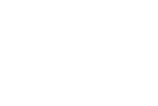

In [35]:
##########USE IF OUTPUT IS CLASSIFIER#############
###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("Out shape X,Y is:",x_result.shape, y_result.shape, ", number of classes:", img_gen.num_classes, ", number of images in each class:", img_gen.num_class_samples)
print("Show first 5 images with it's augmentations:")
example_5_pic = [i+k*img_gen.num_classes for k in range(img_gen.num_class_samples) for  i in range(5)]

Debug.show_images_list(x_result[example_5_pic], y_result[example_5_pic], col_number = 5)

Out shape X,Y is: (100, 256, 256) (100, 1) , number of classes: 100 , number of images in each class: 1
Show first 5 images:


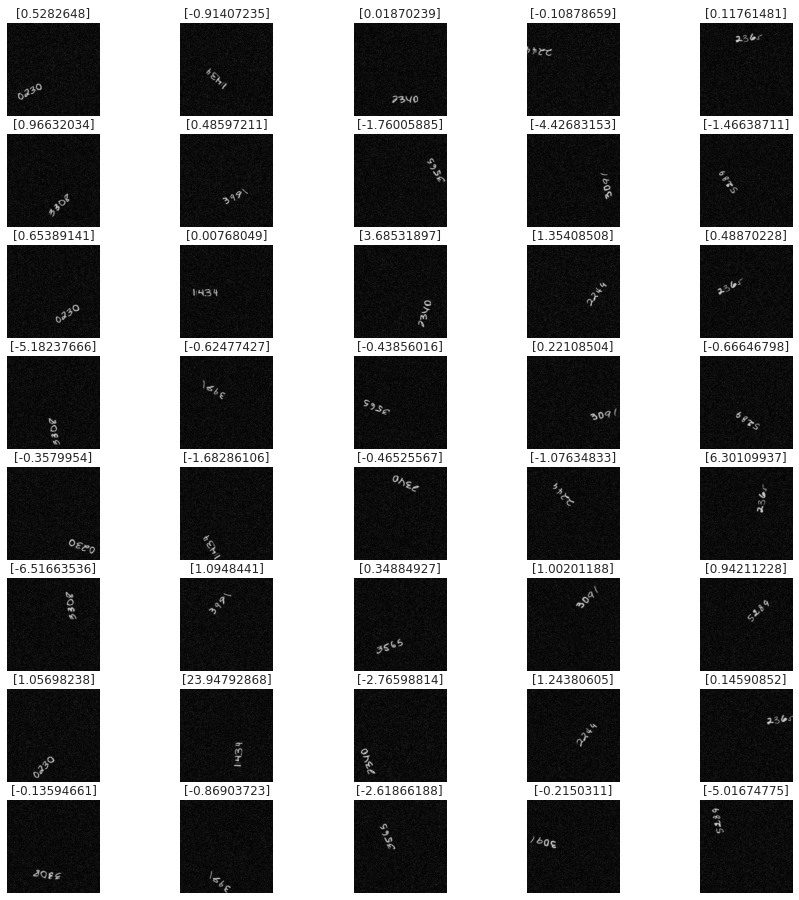

In [48]:
##########USE IF OUTPUT IS FUNCTION#############
###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("Out shape X,Y is:",x_result.shape, y_result.shape, ", number of classes:", img_gen.num_classes, ", number of images in each class:", img_gen.num_class_samples)
print("Show first 5 images:")

Debug.show_images_list(x_result[:40], y_result[:40], col_number = 5)

Out shape X,Y is: (10000, 256, 256) (10000, 256, 256) , number of classes: 1000 , number of images in each class: 10
Show first 5 images:


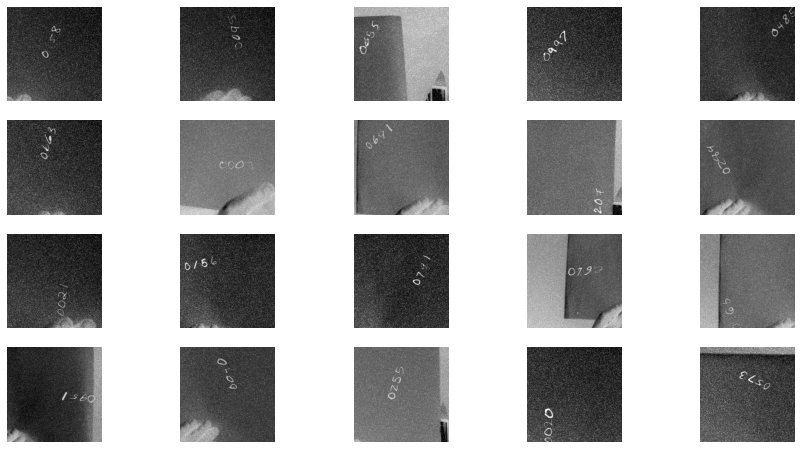

In [13]:
##########USE IF OUTPUT IS PICTURE#############
###Show some report.
print("Out shape X,Y is:",x_result.shape, y_result.shape, ", number of classes:", img_gen.num_classes, ", number of images in each class:", img_gen.num_class_samples)
print("Show first 5 images:")

Debug.show_images_list(x_result[:20], col_number = 5)

Show first 5 images of Y:


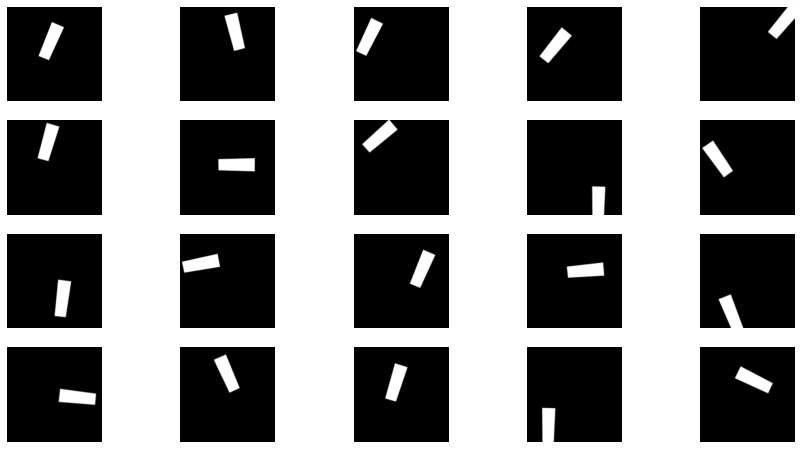

In [14]:
##########USE IF OUTPUT IS PICTURE#############
###Show some report.
print("Show first 5 images of Y:")
Debug.show_images_list(y_result[:20], col_number = 5)

In [12]:
###Shuffle X and Y together
x_result_shuff, y_result_shuff = img_gen.shuffle_x_y(x_result, y_result)

In [15]:
###Save data to file
Image_generator.save_data(x_result_shuff,y_result_shuff, name="base_unet_256x256_select_map")

Data is ok
Out shape X,Y is: (100000, 32, 84) (100000,)
Number of classes: 10000
Max class label (should starts from 0): 9999
Show first 10 images:


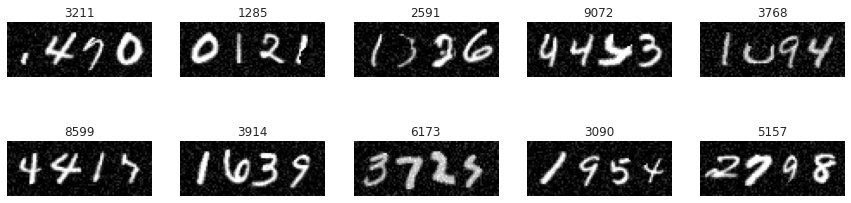

In [5]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = Image_generator.load_data()

###Get information about dataset
y_uniq = len(np.unique(y_load))
y_max = y_load.max()

###Check if data is consistent
print("Data is ok" if (y_max+1)==y_uniq else "Data is NOT consistent! Y values should be from 0 to MAX, without gaps!!!")

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Number of classes:",y_uniq)
print("Max class label (should starts from 0):", y_max)
print("Show first 10 images:")
Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

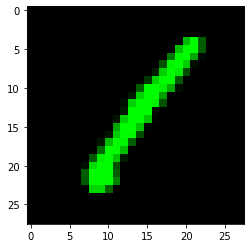

In [149]:
###Some example code that shows gray->rgb conversion
#Make red from gray
x_train_sc1 = Debug.scale_to_1(x_train)
x_train_Rgb = Debug.make_rgb_from_gray(x_train_sc1, mode="g")
Debug.show_image(x_train_Rgb[0])

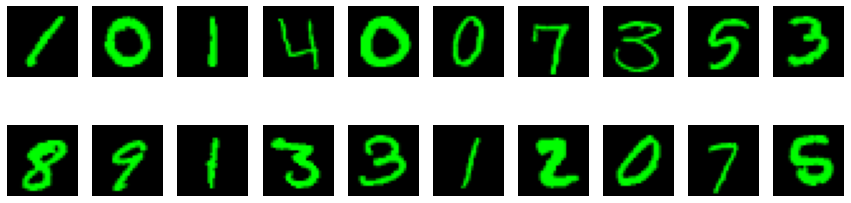

In [273]:
###Some example code that shows gray->rgb conversion
out = Debug.show_images_list(x_train_Rgb)

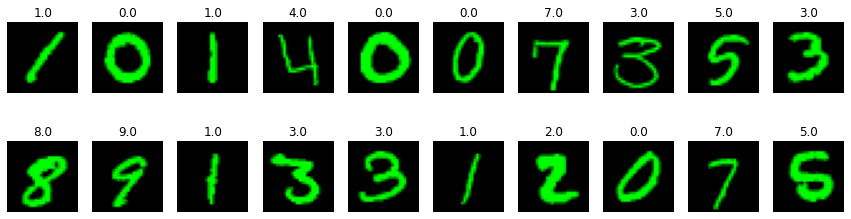

In [277]:
###Some example code that shows usage of labels
#Debug.show_image(img, cmap="gray")
#Debug.show_images_list(x_train_Rgb, y_train) #save_name="out"
Debug.show_images_list(x_train_Rgb, y_train, save_name="out") 

